In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [15]:
df = pd.read_csv("2022_data.csv")

C:\Users\PC\AppData\Local\Temp\ipykernel_6380\951533738.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("2022_data.csv")


In [8]:
df.columns

Index(['지점', '지점명', '일시', '기온(°C)', '기온 QC플래그', '강수량(mm)', '강수량 QC플래그',
       '풍속(m/s)', '풍속 QC플래그', '풍향(16방위)', '풍향 QC플래그', '습도(%)', '습도 QC플래그',
       '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '현지기압 QC플래그', '해면기압(hPa)',
       '해면기압 QC플래그', '일조(hr)', '일조 QC플래그', '일사(MJ/m2)', '일사 QC플래그', '적설(cm)',
       '3시간신적설(cm)', '전운량(10분위)', '중하층운량(10분위)', '운형(운형약어)', '최저운고(100m )',
       '시정(10m)', '지면상태(지면상태코드)', '현상번호(국내식)', '지면온도(°C)', '지면온도 QC플래그',
       '5cm 지중온도(°C)', '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)'],
      dtype='object')

In [141]:
data = df[['지점', '일시', '지면온도(°C)']]

In [142]:
data['일시'] = pd.to_datetime(data['일시'])
data.set_index(['일시'], inplace=True)
data['지면온도(°C)'] = data['지면온도(°C)'].interpolate(method = 'time')

data = data.reset_index(drop = True)

C:\Users\PC\AppData\Local\Temp\ipykernel_6380\1774044981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['일시'] = pd.to_datetime(data['일시'])
C:\Users\PC\AppData\Local\Temp\ipykernel_6380\1774044981.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['지면온도(°C)'] = data['지면온도(°C)'].interpolate(method = 'time')


In [143]:
data['일시'] = df['일시']

In [144]:
data['일시'] = pd.to_datetime(data['일시'])
data.set_index(['일시'], inplace=True)

data = data.groupby('지점').resample('12H').mean()

In [145]:
data

지점  지면온도(°C)
지점  일시                                  
90  2022-02-01 00:00:00   90.0 -0.618182
    2022-02-01 12:00:00   90.0  1.091667
    2022-02-02 00:00:00   90.0 -1.941667
    2022-02-02 12:00:00   90.0  0.966667
    2022-02-03 00:00:00   90.0 -3.241667
...                        ...       ...
295 2023-01-29 12:00:00  295.0  7.775000
    2023-01-30 00:00:00  295.0  0.891667
    2023-01-30 12:00:00  295.0  7.416667
    2023-01-31 00:00:00  295.0 -1.491667
    2023-01-31 12:00:00  295.0  9.766667

[69350 rows x 2 columns]

In [152]:
datas = data.iloc[:, 1]

In [155]:
data = datas.reset_index()

In [294]:
# Create a list of time series for each branch
time_series_list = [group['지면온도(°C)'].values for name, group in data.groupby('지점')]

# Find the maximum length of the time series
max_length = max(len(ts) for ts in time_series_list)

# Pad the time series with NaN values to make them all the same length
time_series_list = [np.pad(ts, (0, max_length - len(ts)), 'constant', constant_values=np.nan) for ts in time_series_list]

# Convert the list of time series to a 3D numpy array
time_series = np.array(time_series_list)
time_series = time_series[..., np.newaxis]  # Add an extra dimension

# Scale the time series
scaler = TimeSeriesScalerMeanVariance()
time_series_scaled = scaler.fit_transform(time_series)

# Apply k-means clustering
kmeans = TimeSeriesKMeans(n_clusters=6, metric='dtw', random_state=0)
labels = kmeans.fit_predict(time_series_scaled)

In [238]:
dtwcluster_label = pd.DataFrame({
    '지점': df['지점'].unique(),
    '지점명' : df['지점명'].unique(),
    'label': labels
})

In [298]:
pd.DataFrame(labels).value_counts()

5    21
4    20
2    18
3    16
1    14
0     6
Name: count, dtype: int64

In [296]:
centroids = kmeans.cluster_centers_

In [295]:
dataset = time_series_scaled

In [290]:
dataset = dataset[:,:,0].shape

In [263]:
from tslearn.metrics import dtw

In [300]:
# labels를 numpy 배열로 변환합니다.
labels = np.array(labels)

# 각 클러스터에 대해 중심점에 가장 가까운 데이터 포인트를 찾습니다.
for i, centroid in enumerate(centroids):
    cluster_indices = np.where(labels == i)[0]
    distances = [(idx, dtw(centroid, dataset[idx])) for idx in cluster_indices]
    closest_datapoint_index, _ = min(distances, key=lambda x: x[1])
    closest_datapoint = dataset[closest_datapoint_index]
    print(f"가장 가까운 데이터 포인트의 인덱스: {closest_datapoint_index}")

가장 가까운 데이터 포인트의 인덱스: 44
가장 가까운 데이터 포인트의 인덱스: 55
가장 가까운 데이터 포인트의 인덱스: 83
가장 가까운 데이터 포인트의 인덱스: 65
가장 가까운 데이터 포인트의 인덱스: 40
가장 가까운 데이터 포인트의 인덱스: 76


In [301]:
dtwcluster_label.loc[[44,55,83,65,40,76], ]

,지점,지점명,label
44,189,서귀포,0
55,232,천안,1
83,276,청송군,2
65,251,고창군,3
40,177,홍성,4
76,263,의령군,5


In [305]:
closest_counts = {2: 3, 3: 2, 4: 2}  # 각 클러스터에서 선택할 데이터 포인트의 개수

for i, centroid in enumerate(centroids):
    if i+1 in closest_counts:
        cluster_indices = np.where(labels == i)[0]
        distances = [(idx, dtw(centroid, dataset[idx])) for idx in cluster_indices]
        closest_datapoints = sorted(distances, key=lambda x: x[1])[:closest_counts[i+1]]
        for j, (idx, dist) in enumerate(closest_datapoints):
            print(f"데이터 포인트의 인덱스: {idx}")

데이터 포인트의 인덱스: 55
데이터 포인트의 인덱스: 13
데이터 포인트의 인덱스: 48
데이터 포인트의 인덱스: 83
데이터 포인트의 인덱스: 23
데이터 포인트의 인덱스: 65
데이터 포인트의 인덱스: 28


In [306]:
dtwcluster_label.loc[[55,13,48,83,23,65,28], ]

,지점,지점명,label
55,232,천안,1
13,114,원주,1
48,203,이천,1
83,276,청송군,2
23,136,안동,2
65,251,고창군,3
28,146,전주,3


In [315]:
element = [114,136,146,177,189,203,232,251,263,276]
dtwcluster_label.loc[dtwcluster_label['지점'].isin(element), ].to_csv("points.csv")

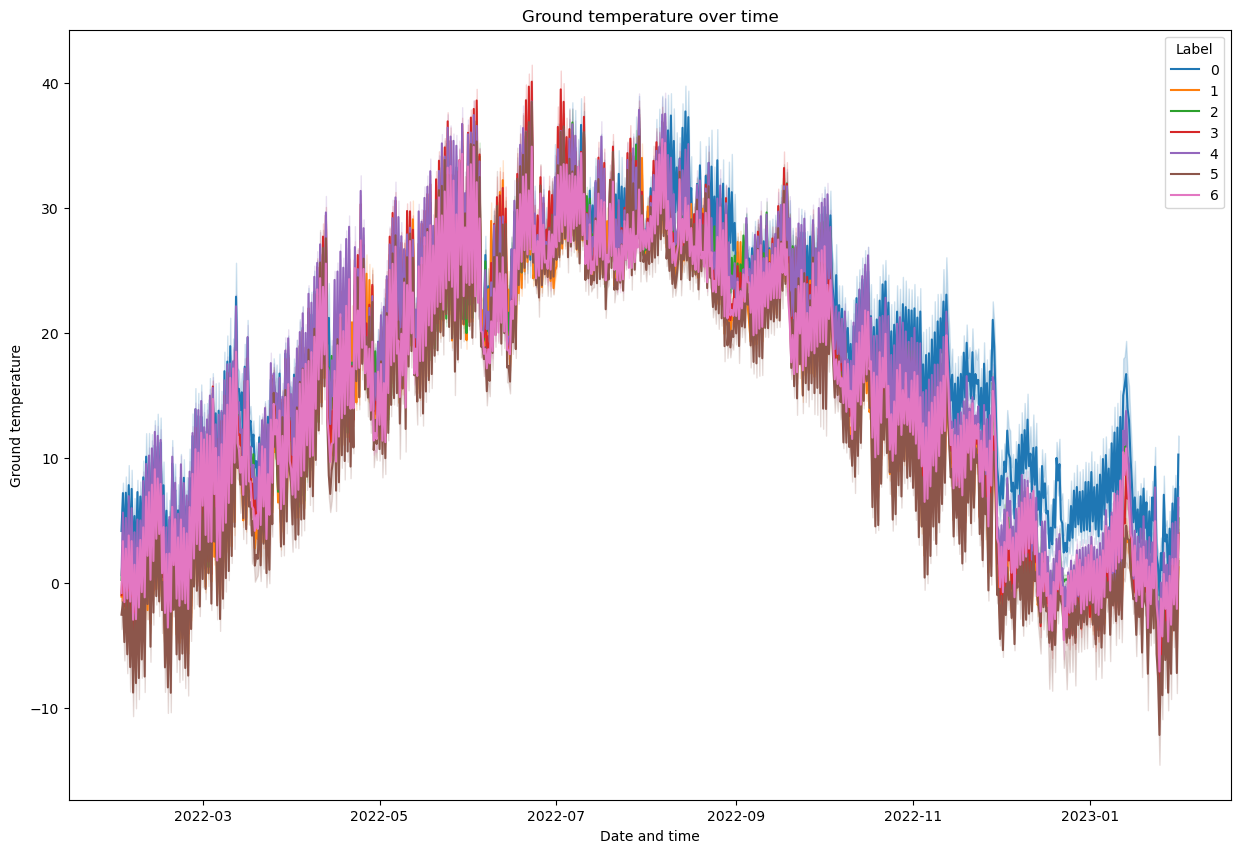

In [307]:
# Now we can create a plot
plt.figure(figsize=(15, 10))

# Create a seaborn lineplot with 'Date and time' on x-axis and 'Ground temperature' on y-axis,
# color-coded by 'label' values.
sns.lineplot(data=cluster_data, x='일시', y='지면온도(°C)', hue='label', palette='tab10')

plt.title('Ground temperature over time')
plt.xlabel('Date and time')
plt.ylabel('Ground temperature')
plt.legend(title='Label')

plt.show()